In [ ]:
import json
import os
from typing import List

# Unstructured for document parsing
from unstructured.partition.pdf import partition_pdf
from unstructured.chunking.title import chunk_by_title

# LangChain components
from langchain_core.documents import Document
from langchain_chroma import Chroma
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv

# FREE AI MODELS - Gemini (vision) + Ollama (text) + HuggingFace (embeddings)
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_ollama import OllamaLLM
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv()

print("\n🆓 Using FREE AI Models:")
print("   📊 Embeddings: HuggingFace (FREE)")
print("   🤖 Text LLM: Ollama (FREE, local)")
print("   👁️  Vision LLM: Google Gemini (FREE tier)")
print("\n💡 Get Gemini API key: https://aistudio.google.com/apikey")
print("   Add to .env: GOOGLE_API_KEY=your_key_here")


🆓 Using FREE AI Models:
   📊 Embeddings: HuggingFace (FREE)
   🤖 LLM: Groq (FREE, ultra-fast)

💡 Get Groq API key: https://console.groq.com/keys
   Add to .env: GROQ_API_KEY=your_key_here


In [ ]:
## 🔧 Initialize FREE AI Models

print("🔧 Initializing models...")

# 1. HuggingFace Embeddings (FREE, local)
print("   Loading embeddings...")
embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-small-en-v1.5",
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True}
)
print("   ✅ Embeddings ready")

# 2. Ollama for text-only tasks (FREE, local, optional)
try:
    llm_text = OllamaLLM(model="llama3.2", temperature=0)
    llm_text.invoke("test")
    print("   ✅ Ollama ready (text)")
except Exception as e:
    print(f"   ⚠️  Ollama not available: {e}")
    llm_text = None

# 3. Gemini for vision tasks (FREE tier)
try:
    llm_vision = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash-exp",
        google_api_key=os.getenv("GOOGLE_API_KEY"),
        temperature=0
    )
    print("   ✅ Gemini ready (vision)")
except Exception as e:
    print(f"   ⚠️  Gemini not available: {e}")
    print("   💡 Get API key: https://aistudio.google.com/apikey")
    llm_vision = None

print("\n✅ Initialization complete!")
print(f"   Embeddings: ✅")
print(f"   Text LLM (Ollama): {'✅' if llm_text else '⚠️  Install Ollama'}")
print(f"   Vision LLM (Gemini): {'✅' if llm_vision else '⚠️  Add GOOGLE_API_KEY to .env'}")

🔧 Initializing models...
   Loading embeddings...


   ✅ Embeddings ready
   ✅ Groq ready (text)

✅ Initialization complete!
   Embeddings: ✅
   LLM (Groq): ✅


In [3]:
## ⚙️ Configure System Dependencies (Tesseract & Poppler)

import pytesseract

# CRITICAL: Set environment variables BEFORE using unstructured
print("⚙️ Configuring system dependencies...")

# Set Tesseract path
TESSERACT_PATH = r'C:\Program Files\Tesseract-OCR'
os.environ["PATH"] = TESSERACT_PATH + os.pathsep + os.environ.get("PATH", "")
os.environ["TESSDATA_PREFIX"] = r'C:\Program Files\Tesseract-OCR\tessdata'
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Set Poppler path
POPPLER_PATH = r'C:\Program Files\poppler\poppler-25.12.0\Library\bin'
os.environ["PATH"] = POPPLER_PATH + os.pathsep + os.environ.get("PATH", "")

print("✅ System dependencies configured:")
print(f"   📍 Tesseract: {TESSERACT_PATH}")
print(f"   📍 Poppler: {POPPLER_PATH}")
print(f"   📍 Tessdata: {os.environ.get('TESSDATA_PREFIX')}")

⚙️ Configuring system dependencies...
✅ System dependencies configured:
   📍 Tesseract: C:\Program Files\Tesseract-OCR
   📍 Poppler: C:\Program Files\poppler\poppler-25.12.0\Library\bin
   📍 Tessdata: C:\Program Files\Tesseract-OCR\tessdata


In [4]:
def partition_document(file_path: str):
    """Extract elements from PDF using unstructured"""
    print(f"📄 Partitioning document: {file_path}")
    
    elements = partition_pdf(
        filename=file_path,
        strategy="hi_res",
        infer_table_structure=True,
        extract_image_block_types=["Image"],
        extract_image_block_to_payload=True,
        languages=["eng"],  # Specify language to avoid warning
        poppler_path=r'C:\Program Files\poppler\poppler-25.12.0\Library\bin'  # Explicit poppler path
    )
    
    print(f"✅ Extracted {len(elements)} elements")
    return elements

# Test with your PDF file
file_path = "./docs/attention-is-all-you-need.pdf"  # Change this to your PDF path
elements = partition_document(file_path)

📄 Partitioning document: ./docs/attention-is-all-you-need.pdf


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


✅ Extracted 220 elements


In [5]:
elements

In [6]:
# All types of different atomic elements we see from unstructured
set([str(type(el)) for el in elements])

{"<class 'unstructured.documents.elements.FigureCaption'>",
 "<class 'unstructured.documents.elements.Footer'>",
 "<class 'unstructured.documents.elements.Formula'>",
 "<class 'unstructured.documents.elements.Header'>",
 "<class 'unstructured.documents.elements.Image'>",
 "<class 'unstructured.documents.elements.ListItem'>",
 "<class 'unstructured.documents.elements.NarrativeText'>",
 "<class 'unstructured.documents.elements.Table'>",
 "<class 'unstructured.documents.elements.Text'>",
 "<class 'unstructured.documents.elements.Title'>"}

In [7]:
elements[36].to_dict()

{'type': 'Title',
 'element_id': '30c710cff05a9418102f1efc82bdcd00',
 'text': '1 Introduction',
 'metadata': {'detection_class_prob': 0.9067491888999939,
  'is_extracted': 'true',
  'coordinates': {'points': ((np.float64(295.11419677734375),
     np.float64(201.40676888888876)),
    (np.float64(295.11419677734375), np.float64(234.61565777777764)),
    (np.float64(536.1755981445312), np.float64(234.61565777777764)),
    (np.float64(536.1755981445312), np.float64(201.40676888888876))),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2026-01-14T20:23:06',
  'filetype': 'application/pdf',
  'languages': ['eng'],
  'page_number': 2,
  'file_directory': './docs',
  'filename': 'attention-is-all-you-need.pdf',
  'parent_id': 'aec8abc3e9fe8bfa4bd1f5d76d93b3c9'}}

In [8]:
# Gather all images
images = [element for element in elements if element.category == 'Image']
print(f"Found {len(images)} images")

images[0].to_dict()

# Use https://codebeautify.org/base64-to-image-converter to view the base64 text

Found 7 images


{'type': 'Image',
 'element_id': '8d5da8004548bcc1bff8190e472cdfe1',
 'text': 'Output Probabilities Add & Norm Feed Forward Add & Norm Multi-Head Attention a, Add & Norm Add & Norm Feed Forward Nx | -+CAgc8 Norm) Add & Norm Masked Multi-Head Multi-Head Attention Attention Se a, ee a, Positional Positional Encoding @ © @ Encoding Input Output Embedding Embedding Inputs Outputs (shifted right)',
 'metadata': {'coordinates': {'points': ((np.float64(545.9972222222221),
     np.float64(200.00555555555542)),
    (np.float64(545.9972222222221), np.float64(1095.6055555555556)),
    (np.float64(1153.997222222222), np.float64(1095.6055555555556)),
    (np.float64(1153.997222222222), np.float64(200.00555555555542))),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2026-01-14T20:23:06',
  'filetype': 'application/pdf',
  'languages': ['eng'],
  'page_number': 3,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8

In [9]:
# Gather all table
tables = [element for element in elements if element.category == 'Table']
print(f"Found {len(tables)} tables")

tables[0].to_dict()

# Use https://jsfiddle.net/ to view the table html 

Found 4 tables


{'type': 'Table',
 'element_id': 'a89281d85d3d589d6b9b2c889815cbce',
 'text': 'Layer Type Complexity per Layer Sequential Maximum Path Length Operations Self-Attention O(n2 · d) O(1) O(1) Recurrent O(n · d2) O(n) O(n) Convolutional O(k · n · d2) O(1) O(logk(n)) Self-Attention (restricted) O(r · n · d) O(1) O(n/r)',
 'metadata': {'detection_class_prob': 0.928255021572113,
  'is_extracted': 'true',
  'coordinates': {'points': ((np.float64(320.3291931152344),
     np.float64(312.45477294921875)),
    (np.float64(320.3291931152344), np.float64(519.1640014648438)),
    (np.float64(1363.98291015625), np.float64(519.1640014648438)),
    (np.float64(1363.98291015625), np.float64(312.45477294921875))),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2026-01-14T20:23:06',
  'text_as_html': '<table><thead><tr><th>Layer Type</th><th>Complexity per Layer</th><th>Sequential Operations</th><th>Maximum Path Length</th></tr></thead><tbody><tr><td>Self-

In [10]:
def create_chunks_by_title(elements):
    """Create intelligent chunks using title-based strategy"""
    print("🔨 Creating smart chunks...")
    
    chunks = chunk_by_title(
        elements, # The parsed PDF elements from previous step
        max_characters=3000, # Hard limit - never exceed 3000 characters per chunk
        new_after_n_chars=2400, # Try to start a new chunk after 2400 characters
        combine_text_under_n_chars=500 # Merge tiny chunks under 500 chars with neighbors
    )
    
    print(f"✅ Created {len(chunks)} chunks")
    return chunks

# Create chunks
chunks = create_chunks_by_title(elements)

🔨 Creating smart chunks...
✅ Created 25 chunks


In [11]:
# All unique types
set([str(type(chunk)) for chunk in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [12]:
chunks

In [13]:
# View a single chunk
chunks[2].to_dict()

{'type': 'CompositeElement',
 'element_id': '20719461-57fd-4809-892b-e7c63d668b9c',
 'text': '1 Introduction\n\nRecurrent neural networks, long short-term memory [13] and gated recurrent [7] neural networks in particular, have been firmly established as state of the art approaches in sequence modeling and transduction problems such as language modeling and machine translation [35, 2, 5]. Numerous efforts have since continued to push the boundaries of recurrent language models and encoder-decoder architectures [38, 24, 15].\n\nRecurrent models typically factor computation along the symbol positions of the input and output sequences. Aligning the positions to steps in computation time, they generate a sequence of hidden states ht, as a function of the previous hidden state ht−1 and the input for position t. This inherently sequential nature precludes parallelization within training examples, which becomes critical at longer sequence lengths, as memory constraints limit batching across ex

In [14]:
chunks[11].metadata.orig_elements[-1].to_dict()

{'type': 'Table',
 'element_id': 'a89281d85d3d589d6b9b2c889815cbce',
 'text': 'Layer Type Complexity per Layer Sequential Maximum Path Length Operations Self-Attention O(n2 · d) O(1) O(1) Recurrent O(n · d2) O(n) O(n) Convolutional O(k · n · d2) O(1) O(logk(n)) Self-Attention (restricted) O(r · n · d) O(1) O(n/r)',
 'metadata': {'detection_class_prob': 0.928255021572113,
  'is_extracted': 'true',
  'coordinates': {'points': ((np.float64(320.3291931152344),
     np.float64(312.45477294921875)),
    (np.float64(320.3291931152344), np.float64(519.1640014648438)),
    (np.float64(1363.98291015625), np.float64(519.1640014648438)),
    (np.float64(1363.98291015625), np.float64(312.45477294921875))),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2026-01-14T20:23:06',
  'text_as_html': '<table><thead><tr><th>Layer Type</th><th>Complexity per Layer</th><th>Sequential Operations</th><th>Maximum Path Length</th></tr></thead><tbody><tr><td>Self-

In [ ]:
def separate_content_types(chunk):
    """Analyze what types of content are in a chunk"""
    content_data = {
        'text': chunk.text,
        'tables': [],
        'images': [],
        'types': ['text']
    }
    
    # Check for tables and images in original elements
    if hasattr(chunk, 'metadata') and hasattr(chunk.metadata, 'orig_elements'):
        for element in chunk.metadata.orig_elements:
            element_type = type(element).__name__
            
            # Handle tables
            if element_type == 'Table':
                content_data['types'].append('table')
                table_html = getattr(element.metadata, 'text_as_html', element.text)
                content_data['tables'].append(table_html)
            
            # Handle images
            elif element_type == 'Image':
                if hasattr(element, 'metadata') and hasattr(element.metadata, 'image_base64'):
                    content_data['types'].append('image')
                    content_data['images'].append(element.metadata.image_base64)
    
    content_data['types'] = list(set(content_data['types']))
    return content_data

def create_ai_enhanced_summary(text: str, tables: List[str], images: List[str]) -> str:
    """Create AI-enhanced summary using Gemini (FREE, with vision support)"""
    
    # Use Gemini for vision, Ollama for text-only
    llm = llm_vision if images else llm_text
    
    if llm is None:
        summary = f"{text[:500]}..."
        if tables:
            summary += f"\n[Contains {len(tables)} table(s)]"
        if images:
            summary += f"\n[Contains {len(images)} image(s)]"
        return summary
    
    try:
        # Build the prompt
        prompt_text = f"""Create a detailed, searchable summary of this document content.

TEXT CONTENT:
{text}

"""
        
        # Add tables if present
        if tables:
            prompt_text += "\nTABLES:\n"
            for i, table in enumerate(tables, 1):
                prompt_text += f"\nTable {i}:\n{table}\n"
        
        prompt_text += """

Generate a comprehensive summary that:
1. Extracts key facts, numbers, and data points
2. Identifies main topics and concepts
3. Lists questions this content could answer
4. Describes visual elements (charts, diagrams, patterns)
5. Suggests alternative search terms

Keep it detailed and searchable."""

        # If there are images, use Gemini with vision
        if images:
            message_content = [{"type": "text", "text": prompt_text}]
            for image_base64 in images:
                message_content.append({
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}
                })
            message = HumanMessage(content=message_content)
            response = llm.invoke([message])
            return response.content
        else:
            # Text-only, use Ollama
            response = llm.invoke(prompt_text)
            return response
        
    except Exception as e:
        print(f"     ❌ AI summary failed: {e}")
        # Fallback to simple summary
        summary = f"{text[:300]}..."
        if tables:
            summary += f" [Contains {len(tables)} table(s)]"
        if images:
            summary += f" [Contains {len(images)} image(s)]"
        return summary

def summarise_chunks(chunks):
    """Process all chunks with AI Summaries"""
    print("🧠 Processing chunks with AI Summaries...")
    
    langchain_documents = []
    total_chunks = len(chunks)
    
    for i, chunk in enumerate(chunks):
        current_chunk = i + 1
        print(f"   Processing chunk {current_chunk}/{total_chunks}")
        
        # Analyze chunk content
        content_data = separate_content_types(chunk)
        
        # Debug prints
        print(f"     Types found: {content_data['types']}")
        print(f"     Tables: {len(content_data['tables'])}, Images: {len(content_data['images'])}")
        
        # Create AI-enhanced summary if chunk has tables/images
        if content_data['tables'] or content_data['images']:
            print(f"     → Creating AI summary for mixed content...")
            try:
                enhanced_content = create_ai_enhanced_summary(
                    content_data['text'],
                    content_data['tables'], 
                    content_data['images']
                )
                print(f"     → AI summary created successfully")
                print(f"     → Enhanced content preview: {enhanced_content[:200]}...")
            except Exception as e:
                print(f"     ❌ AI summary failed: {e}")
                enhanced_content = content_data['text']
        else:
            print(f"     → Using raw text (no tables/images)")
            enhanced_content = content_data['text']
        
        # Create LangChain Document with rich metadata
        doc = Document(
            page_content=enhanced_content,
            metadata={
                "original_content": json.dumps({
                    "raw_text": content_data['text'],
                    "tables_html": content_data['tables'],
                    "images_base64": content_data['images']
                })
            }
        )
        
        langchain_documents.append(doc)
    
    print(f"✅ Processed {len(langchain_documents)} chunks")
    return langchain_documents


# Process chunks with AI
processed_chunks = summarise_chunks(chunks)

🧠 Processing chunks with AI Summaries...
   Processing chunk 1/25
     Types found: ['text']
     Tables: 0, Images: 0
     → Using raw text (no tables/images)
   Processing chunk 2/25
     Types found: ['text']
     Tables: 0, Images: 0
     → Using raw text (no tables/images)
   Processing chunk 3/25
     Types found: ['text']
     Tables: 0, Images: 0
     → Using raw text (no tables/images)
   Processing chunk 4/25
     Types found: ['text']
     Tables: 0, Images: 0
     → Using raw text (no tables/images)
   Processing chunk 5/25
     Types found: ['image', 'text']
     Tables: 0, Images: 1
     → Creating AI summary for mixed content...
     → AI summary created successfully
     → Enhanced content preview: **Summary of Model Architecture**

**Key Facts, Numbers, and Data Points:**

* The model architecture is based on an encoder-decoder structure.
* The encoder maps an input sequence of symbol represent...
   Processing chunk 6/25
     Types found: ['text']
     Tables: 0, Imag

In [17]:
processed_chunks

[Document(metadata={'original_content': '{"raw_text": "3\\n\\n2023\\n\\n2\\n\\n0\\n\\n2\\n\\ng u A 2 ] L C . s c [ 7 v 2 6 7 3 0 . 6 0\\n\\n7\\n\\n1\\n\\n:\\n\\nv\\n\\narXiv\\n\\ni\\n\\nX\\n\\nr\\n\\na\\n\\nProvided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.\\n\\nAttention Is All You Need\\n\\nAshish Vaswani\\u2217\\n\\nGoogle Brain\\n\\navaswani@google.com\\n\\nNoam Shazeer\\u2217 Google Brain noam@google.com\\n\\nNiki Parmar\\u2217 Google Research nikip@google.com\\n\\nJakob Uszkoreit\\u2217\\n\\nGoogle Research usz@google.com\\n\\nLlion Jones\\u2217\\n\\nGoogle Research llion@google.com\\n\\nAidan N. Gomez\\u2217 \\u2020 University of Toronto aidan@cs.toronto.edu\\n\\n\\u0141ukasz Kaiser\\u2217 Google Brain lukaszkaiser@google.com", "tables_html": [], "images_base64": []}'}, page_content='3\n\n2023\n\n2\n\n0\n\n2\n\ng u A 2 ] L C . s c [ 7 v 2 6 7 3 0 . 6 0\n\n7\

In [18]:
def export_chunks_to_json(chunks, filename="chunks_export.json"):
    """Export processed chunks to clean JSON format"""
    export_data = []
    
    for i, doc in enumerate(chunks):
        chunk_data = {
            "chunk_id": i + 1,
            "enhanced_content": doc.page_content,
            "metadata": {
                "original_content": json.loads(doc.metadata.get("original_content", "{}"))
            }
        }
        export_data.append(chunk_data)
    
    # Save to file
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(export_data, f, indent=2, ensure_ascii=False)
    
    print(f"✅ Exported {len(export_data)} chunks to {filename}")
    return export_data

# Export your chunks
json_data = export_chunks_to_json(processed_chunks)

✅ Exported 25 chunks to chunks_export.json


In [19]:
def create_vector_store(documents, persist_directory="dbv1/chroma_db"):
    """Create and persist ChromaDB vector store using FREE HuggingFace embeddings"""
    print("🔮 Creating embeddings and storing in ChromaDB (FREE - HuggingFace)...")
        
    # Use global embeddings from Cell 1 (HuggingFace, FREE)
    embedding_model = embeddings
    
    # Create ChromaDB vector store
    print("--- Creating vector store ---")
    vectorstore = Chroma.from_documents(
        documents=documents,
        embedding=embedding_model,
        persist_directory=persist_directory, 
        collection_metadata={"hnsw:space": "cosine"}
    )
    print("--- Finished creating vector store ---")
    
    print(f"✅ Vector store created and saved to {persist_directory}")
    return vectorstore

# Create the vector store
db = create_vector_store(processed_chunks)

🔮 Creating embeddings and storing in ChromaDB (FREE - HuggingFace)...
--- Creating vector store ---
--- Finished creating vector store ---
✅ Vector store created and saved to dbv1/chroma_db


In [20]:
# After your retrieval
query = "What are the two main components of the Transformer architecture? "
retriever = db.as_retriever(search_kwargs={"k": 3})
chunks = retriever.invoke(query)

# Export to JSON
export_chunks_to_json(chunks, "rag_results.json")

✅ Exported 3 chunks to rag_results.json


[{'chunk_id': 1,
  'enhanced_content': '**Summary of Model Architecture**\n\n**Key Facts, Numbers, and Data Points:**\n\n* The model architecture is based on an encoder-decoder structure.\n* The encoder maps an input sequence of symbol representations (x1,...,xn) to a sequence of continuous representations z = (z1,...,zn).\n* The decoder generates an output sequence (y1,...,ym) of symbols one element at a time.\n* The model is auto-regressive, consuming previously generated symbols as additional input when generating the next.\n* The Transformer model uses stacked self-attention and point-wise, fully connected layers for both the encoder and decoder.\n* The model architecture is illustrated in Figure 1, which shows the left and right halves of the Transformer model.\n\n**Main Topics and Concepts:**\n\n* Model architecture\n* Encoder-decoder structure\n* Auto-regressive models\n* Transformer model\n* Stacked self-attention\n* Point-wise, fully connected layers\n* Neural sequence transdu

In [22]:
def run_complete_ingestion_pipeline(pdf_path: str):
    """Run the complete RAG ingestion pipeline"""
    print("🚀 Starting RAG Ingestion Pipeline")
    print("=" * 50)
    
    # Step 1: Partition
    elements = partition_document(pdf_path)
    
    # Step 2: Chunk
    chunks = create_chunks_by_title(elements)
    
    # Step 3: AI Summarisation
    summarised_chunks = summarise_chunks(chunks)
    
    # Step 4: Vector Store
    db = create_vector_store(summarised_chunks, persist_directory="dbv2/chroma_db")
    
    print("🎉 Pipeline completed successfully!")
    return db

# Run the complete pipeline

In [23]:
db = run_complete_ingestion_pipeline("./docs/attention-is-all-you-need.pdf")

🚀 Starting RAG Ingestion Pipeline
📄 Partitioning document: ./docs/attention-is-all-you-need.pdf
✅ Extracted 220 elements
🔨 Creating smart chunks...
✅ Created 25 chunks
🧠 Processing chunks with AI Summaries...
   Processing chunk 1/25
     Types found: ['text']
     Tables: 0, Images: 0
     → Using raw text (no tables/images)
   Processing chunk 2/25
     Types found: ['text']
     Tables: 0, Images: 0
     → Using raw text (no tables/images)
   Processing chunk 3/25
     Types found: ['text']
     Tables: 0, Images: 0
     → Using raw text (no tables/images)
   Processing chunk 4/25
     Types found: ['text']
     Tables: 0, Images: 0
     → Using raw text (no tables/images)
   Processing chunk 5/25
     Types found: ['image', 'text']
     Tables: 0, Images: 1
     → Creating AI summary for mixed content...
     → AI summary created successfully
     → Enhanced content preview: **Summary of Model Architecture**

**Key Facts, Numbers, and Data Points:**

1. The document discusses the a

In [ ]:
# Query the vector store
query = "How many attention heads does the Transformer use, and what is the dimension of each head? "

retriever = db.as_retriever(search_kwargs={"k": 3})
chunks = retriever.invoke(query)

def generate_final_answer(chunks, query):
    """Generate final answer using Gemini (FREE, with vision support)"""
    
    # Check if chunks contain images
    has_images = any(
        "original_content" in chunk.metadata and 
        json.loads(chunk.metadata.get("original_content", "{}")).get("images_base64", [])
        for chunk in chunks
    )
    
    # Use Gemini for vision, Ollama for text-only
    llm = llm_vision if has_images else llm_text
    
    if llm is None:
        return "⚠️  No LLM available. Install Ollama or add GOOGLE_API_KEY to .env"
    
    try:
        # Build the text prompt
        prompt_text = f"""Based on the following documents, please answer this question: {query}

CONTENT TO ANALYZE:
"""
        
        for i, chunk in enumerate(chunks):
            prompt_text += f"--- Document {i+1} ---\n"
            
            if "original_content" in chunk.metadata:
                original_data = json.loads(chunk.metadata["original_content"])
                
                # Add raw text
                raw_text = original_data.get("raw_text", "")
                if raw_text:
                    prompt_text += f"TEXT:\n{raw_text}\n\n"
                
                # Add tables as HTML
                tables_html = original_data.get("tables_html", [])
                if tables_html:
                    prompt_text += "TABLES:\n"
                    for j, table in enumerate(tables_html):
                        prompt_text += f"Table {j+1}:\n{table}\n\n"
            
            prompt_text += "\n"
        
        prompt_text += """
Please provide a clear, comprehensive answer using the text, tables, and images above. If the documents don't contain sufficient information to answer the question, say "I don't have enough information to answer that question based on the provided documents."

ANSWER:"""

        # If there are images, use Gemini with vision
        if has_images:
            message_content = [{"type": "text", "text": prompt_text}]
            
            # Add all images from all chunks
            for chunk in chunks:
                if "original_content" in chunk.metadata:
                    original_data = json.loads(chunk.metadata["original_content"])
                    images_base64 = original_data.get("images_base64", [])
                    
                    for image_base64 in images_base64:
                        message_content.append({
                            "type": "image_url",
                            "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}
                        })
            
            message = HumanMessage(content=message_content)
            response = llm.invoke([message])
            return response.content
        else:
            # Text-only, use Ollama
            response = llm.invoke(prompt_text)
            return response
        
    except Exception as e:
        print(f"❌ Answer generation failed: {e}")
        return "Sorry, I encountered an error while generating the answer."

# Usage
final_answer = generate_final_answer(chunks, query)
print(final_answer)

Based on the provided documents, I can answer the question as follows:

**What is Attention?**
Attention is a function that maps a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

**What is the formula for Scaled Dot-Product Attention?**
The formula for Scaled Dot-Product Attention is:

Attention(Q, K, V) = softmax(QK^T / √dk) * V

where:
- Q is the matrix of queries
- K is the matrix of keys
- V is the matrix of values
- dk is the dimension of the keys and queries
- ^T denotes the transpose of the matrix
- softmax is the softmax function
- * denotes matrix multiplication

This formula computes the attention function on a set of queries simultaneously, packed together into a matrix Q, and returns the matrix of outputs. The scaling factor 1/√dk is used t

🤖 Generating answer with Groq...




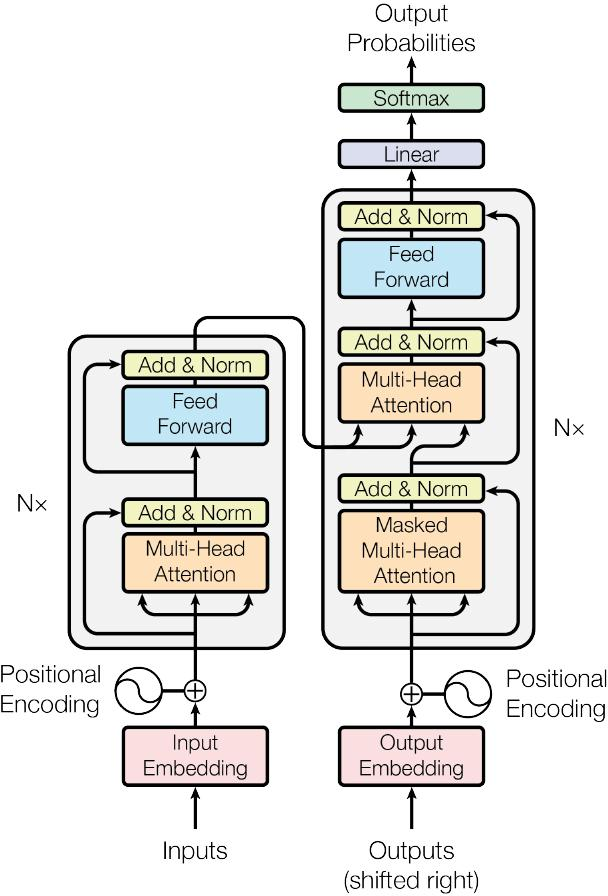


📊 Summary: 3 chunks, 2 tables, 1 images


🤖 Generating answer with Groq...




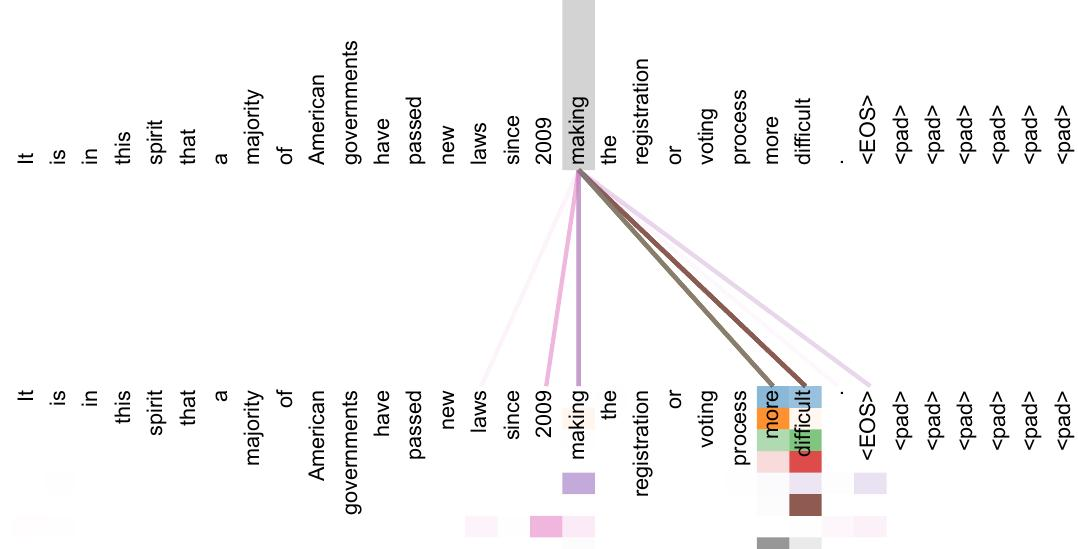
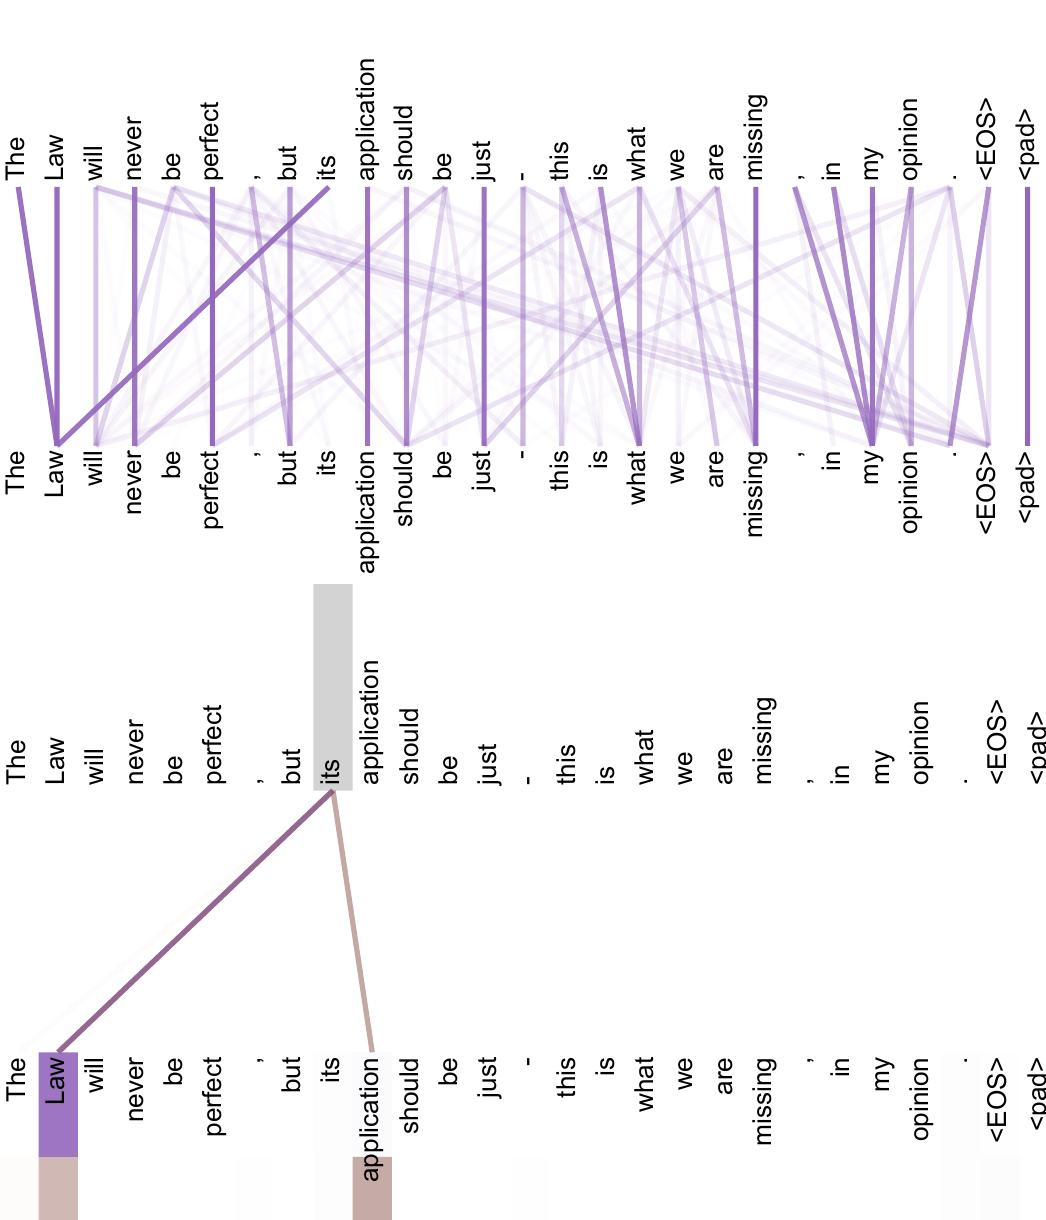
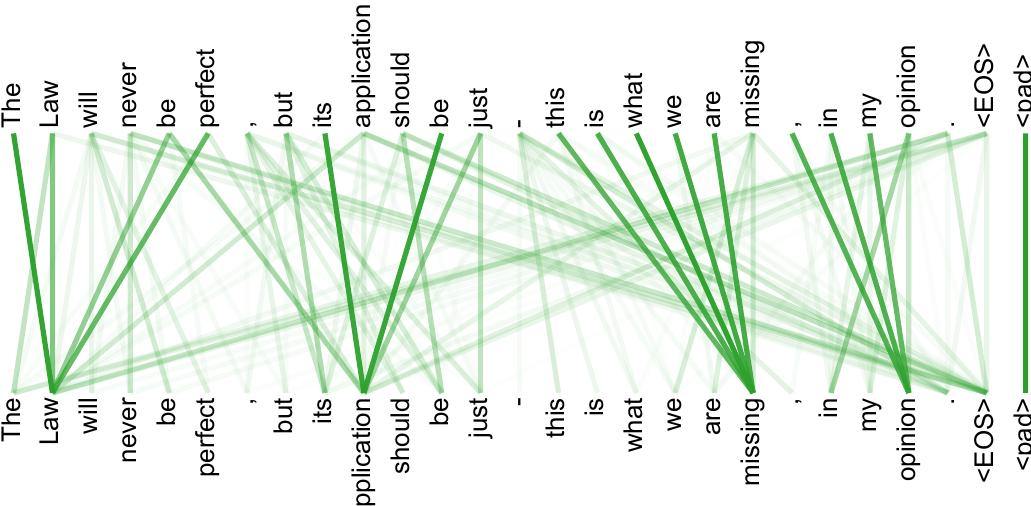
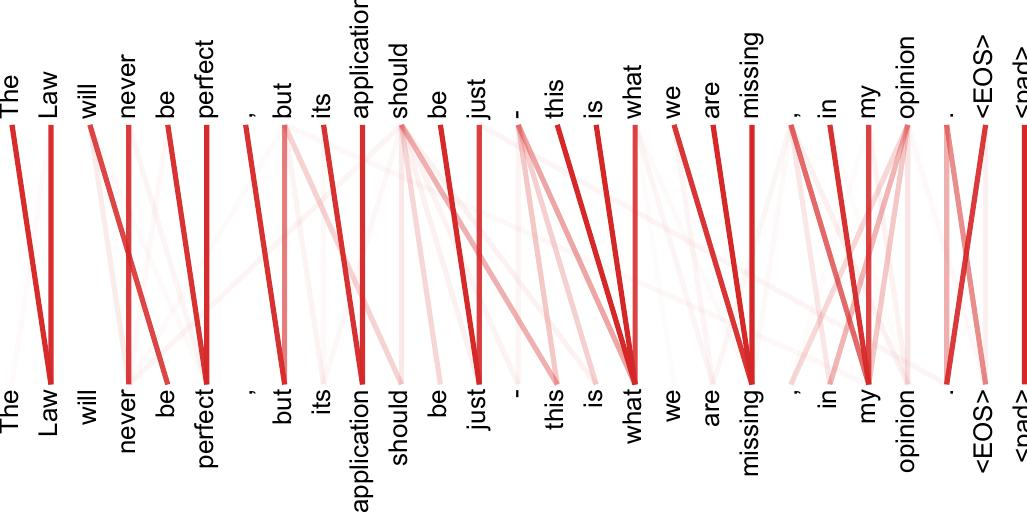